In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list a ll files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 17 07:04:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
#                 transforms.ColorJitter(hue=.1, saturation=.1),
#                 transforms.RandomAdjustSharpness(0, p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:  
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
#     def _prepare_sample(self, image):
#         image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
#         return np.array(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
Path('train/simpsons_dataset')

PosixPath('train/simpsons_dataset')

In [10]:
TRAIN_DIR = Path(r'../input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path(r'../input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

## Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 
## ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
## $input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet
## Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
##  Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [13]:
train_dataset = SimpsonsDataset(train_files, mode='train')

In [14]:
pd.Series(train_dataset.labels).value_counts()

homer_simpson               1684
ned_flanders                1090
moe_szyslak                 1089
lisa_simpson                1015
bart_simpson                1006
marge_simpson                968
krusty_the_clown             904
charles_montgomery_burns     895
principal_skinner            895
milhouse_van_houten          809
chief_wiggum                 739
abraham_grampa_simpson       685
sideshow_bob                 658
apu_nahasapeemapetilon       467
kent_brockman                373
comic_book_guy               352
edna_krabappel               343
nelson_muntz                 269
lenny_leonard                233
mayor_quimby                 185
waylon_smithers              136
maggie_simpson                96
groundskeeper_willie          91
barney_gumble                 80
selma_bouvier                 77
carl_carlson                  74
ralph_wiggum                  67
patty_bouvier                 54
martin_prince                 53
professor_john_frink          49
snake_jail

In [15]:
pd.Series(train_val_labels).value_counts()


homer_simpson               2246
ned_flanders                1454
moe_szyslak                 1452
lisa_simpson                1354
bart_simpson                1342
marge_simpson               1291
krusty_the_clown            1206
principal_skinner           1194
charles_montgomery_burns    1193
milhouse_van_houten         1079
chief_wiggum                 986
abraham_grampa_simpson       913
sideshow_bob                 877
apu_nahasapeemapetilon       623
kent_brockman                498
comic_book_guy               469
edna_krabappel               457
nelson_muntz                 358
lenny_leonard                310
mayor_quimby                 246
waylon_smithers              181
maggie_simpson               128
groundskeeper_willie         121
barney_gumble                106
selma_bouvier                103
carl_carlson                  98
ralph_wiggum                  89
patty_bouvier                 72
martin_prince                 71
professor_john_frink          65
snake_jail

In [16]:
# mean_count = round(pd.Series(train_val_labels).value_counts().mean())
# median_count = round(pd.Series(train_val_labels).value_counts().median())

## Наблюдаем дисбаланс классов, что плохо повлияет на нашу модель. Cтоит применить аугментации. И увеличить количество классов ниже медианного или среднего до медианного или среднего. (Лучше всего показал результат 100)

In [17]:
def make_dict_paths(train_files, train_labels):
    dct = {}
    for label in np.unique(train_labels):
        dct[label] = []
    
    for path, label in zip(train_files, train_labels):
        dct[label].append(path)
    return dct


In [18]:
dict_persons_train = make_dict_paths(train_files, train_dataset.labels)

In [19]:
for person in dict_persons_train:
    if len(dict_persons_train[person]) < 100:
        dict_persons_train[person] = dict_persons_train[person] * (100 // len(dict_persons_train[person]))
        dict_persons_train[person].extend(dict_persons_train[person][:100 - len(dict_persons_train[person])])


In [20]:
for person in dict_persons_train:
    print(f"{person}\t{len(dict_persons_train[person])}")
new_train_files = []

for person in dict_persons_train:
    new_train_files.extend(dict_persons_train[person])

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


# Давайте посмотрим на наших героев внутри датасета.

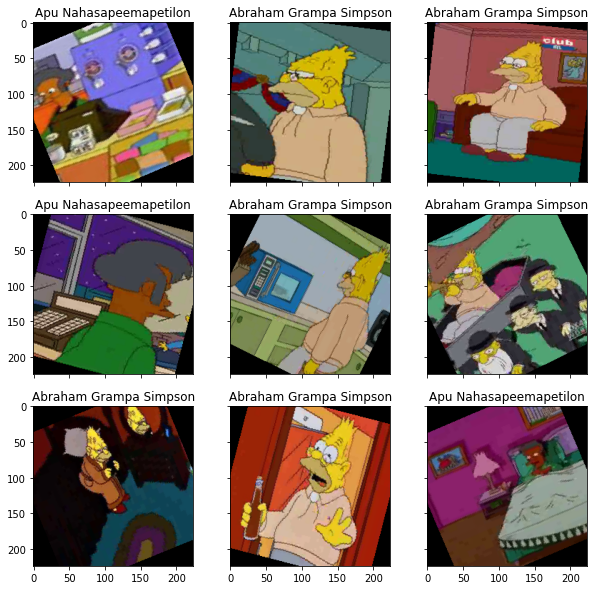

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

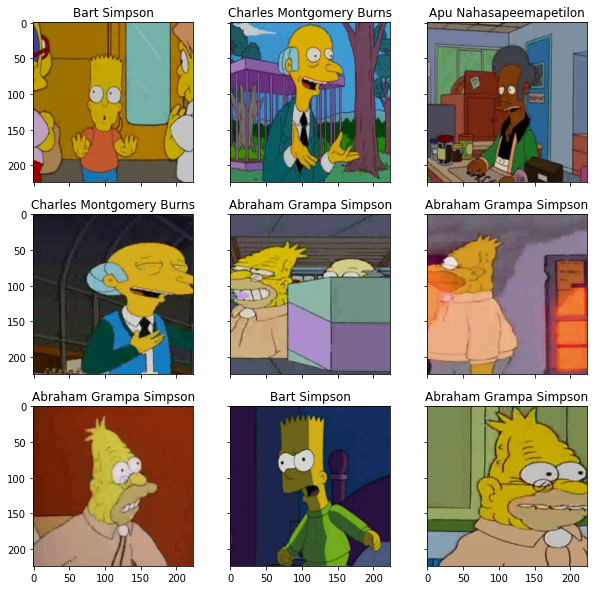

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

In [23]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [24]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [25]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [26]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [27]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [28]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

# Запустим обучение сети.

In [29]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
# train_dataset = SimpsonsDataset(train_files, mode='train')
train_dataset = SimpsonsDataset(new_train_files, mode='train')


In [30]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=128)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.803007996720864


epoch:  50%|█████     | 1/2 [03:40<03:40, 220.49s/it]


Epoch 001 train_loss: 2.8030     val_loss 2.2261 train_acc 0.2066 val_acc 0.3880
loss 1.987904720618267


epoch: 100%|██████████| 2/2 [05:55<00:00, 177.99s/it]


Epoch 002 train_loss: 1.9879     val_loss 1.6368 train_acc 0.4543 val_acc 0.5539


In [31]:
# history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

In [32]:
loss, acc, val_loss, val_acc = zip(*history)

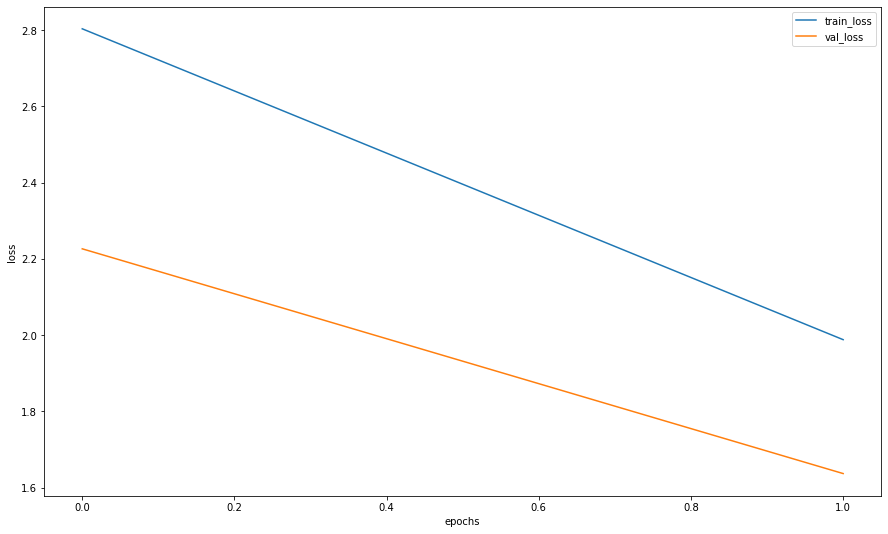

In [33]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Хорошо бы понять, как сделать сабмит. У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [34]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [35]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [36]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [37]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [38]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

# preds_class = [label_encoder.classes_[i] for i in y_pred]

# Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [39]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred.tolist(),average='weighted')

0.55

# Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

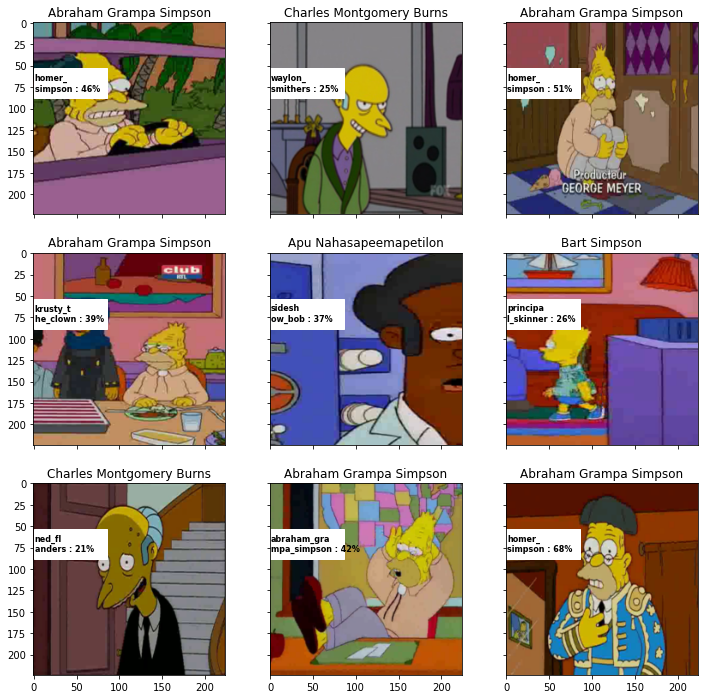

In [40]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

## Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

In [41]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [42]:
d = {'Id':test_filenames, 'Expected':preds}
sub_0 = pd.DataFrame(data=d)
sub_0.to_csv('sub_0.csv', index=False)

In [43]:
pd.read_csv('/kaggle/working/sub_0.csv')

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,sideshow_bob
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,charles_montgomery_burns
987,img988.jpg,sideshow_bob
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [44]:
! ls 

__notebook__.ipynb  label_encoder.pkl  sub_0.csv


In [45]:
# Освободим кэж видеопамяти
torch.cuda.empty_cache() 

# GoogleNet

In [46]:
from torchvision import models

In [47]:
model_google = models.googlenet(pretrained=True).to(DEVICE)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [48]:
child_counter = 0
for child in model_google.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

 child 0 is:
BasicConv2d(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
 child 1 is:
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
 child 2 is:
BasicConv2d(
  (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
 child 3 is:
BasicConv2d(
  (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
 child 4 is:
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
 child 5 is:
Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2

In [49]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for i, child in enumerate(model_google.children()):
    if i not in [x for x in range(9,17)]: # Заморозим первые 8 слоев
        for param in child.parameters():
            param.requires_grad = False

model_google.fc = nn.Sequential(nn.Linear(1024,42))

In [50]:
model_google = model_google.to(DEVICE)

In [51]:
history = train(train_dataset, val_dataset, model=model_google, epochs=15,  
                batch_size=64
               )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.7001003959389543


epoch:   7%|▋         | 1/15 [02:38<37:03, 158.84s/it]


Epoch 001 train_loss: 0.7001     val_loss 0.3333 train_acc 0.8288 val_acc 0.9106
loss 0.5410341834970818


epoch:  13%|█▎        | 2/15 [05:17<34:21, 158.55s/it]


Epoch 002 train_loss: 0.5410     val_loss 0.3276 train_acc 0.8594 val_acc 0.9131
loss 0.2683080307299232


epoch:  20%|██        | 3/15 [07:58<31:59, 159.96s/it]


Epoch 003 train_loss: 0.2683     val_loss 0.2270 train_acc 0.9280 val_acc 0.9391
loss 0.21387277477395786


epoch:  27%|██▋       | 4/15 [10:37<29:12, 159.32s/it]


Epoch 004 train_loss: 0.2139     val_loss 0.2494 train_acc 0.9425 val_acc 0.9404
loss 0.17388572328831184


epoch:  33%|███▎      | 5/15 [13:29<27:19, 163.96s/it]


Epoch 005 train_loss: 0.1739     val_loss 0.2211 train_acc 0.9521 val_acc 0.9402
loss 0.17754658127049788


epoch:  40%|████      | 6/15 [16:11<24:31, 163.51s/it]


Epoch 006 train_loss: 0.1775     val_loss 0.1975 train_acc 0.9506 val_acc 0.9540
loss 0.15524304435958028


epoch:  47%|████▋     | 7/15 [19:01<22:03, 165.49s/it]


Epoch 007 train_loss: 0.1552     val_loss 0.1940 train_acc 0.9582 val_acc 0.9519
loss 0.128719235946526


epoch:  53%|█████▎    | 8/15 [21:40<19:02, 163.27s/it]


Epoch 008 train_loss: 0.1287     val_loss 0.2077 train_acc 0.9656 val_acc 0.9494
loss 0.12122794920768777


epoch:  60%|██████    | 9/15 [24:18<16:11, 161.84s/it]


Epoch 009 train_loss: 0.1212     val_loss 0.2402 train_acc 0.9678 val_acc 0.9421
loss 0.11327498017303969


epoch:  67%|██████▋   | 10/15 [26:56<13:23, 160.70s/it]


Epoch 010 train_loss: 0.1133     val_loss 0.1970 train_acc 0.9667 val_acc 0.9557
loss 0.1098440322933482


epoch:  73%|███████▎  | 11/15 [29:36<10:41, 160.29s/it]


Epoch 011 train_loss: 0.1098     val_loss 0.1954 train_acc 0.9700 val_acc 0.9534
loss 0.09413968656552758


epoch:  80%|████████  | 12/15 [32:14<07:58, 159.63s/it]


Epoch 012 train_loss: 0.0941     val_loss 0.2032 train_acc 0.9739 val_acc 0.9524
loss 0.0940855066382116


epoch:  87%|████████▋ | 13/15 [34:52<05:18, 159.15s/it]


Epoch 013 train_loss: 0.0941     val_loss 0.2194 train_acc 0.9741 val_acc 0.9526
loss 0.09140516740351819


epoch:  93%|█████████▎| 14/15 [37:30<02:38, 158.84s/it]


Epoch 014 train_loss: 0.0914     val_loss 0.1855 train_acc 0.9750 val_acc 0.9597
loss 0.09718971514104738


epoch: 100%|██████████| 15/15 [40:08<00:00, 160.57s/it]


Epoch 015 train_loss: 0.0972     val_loss 0.1941 train_acc 0.9738 val_acc 0.9536


In [52]:
import copy

# сохранить веса нашей нейросети model
model_pre_weights = copy.deepcopy(model_google.state_dict())
torch.save(model_pre_weights, "path_to\\model_pre_weights.pth")
model_google.load_state_dict(torch.load("path_to\\model_pre_weights.pth"))

<All keys matched successfully>

In [53]:
# # Включаем все слои!!!
# for child in model_google.children():
#     for param in child.parameters():
#         param.requires_grad = True

In [54]:
# torch.cuda.empty_cache()

In [55]:
# history = train(train_dataset, val_dataset, model=model_google, epochs=19, batch_size=64)

In [56]:
# # сохранить веса нашей нейросети model
# model_25epoch_weights = copy.deepcopy(model_google.state_dict())
# torch.save(model_25epoch_weights, "path_to\\model_25epoch_weights.pth")

In [57]:
# # загружаем сохраненное состояние весов нейросети
# model_google.load_state_dict(torch.load("path_to\\model_25epoch_weights.pth"))

Заморозка первых слоев положительно сказывается на быстродействии и качестве модели.

In [58]:
loss, acc, val_loss, val_acc = zip(*history)

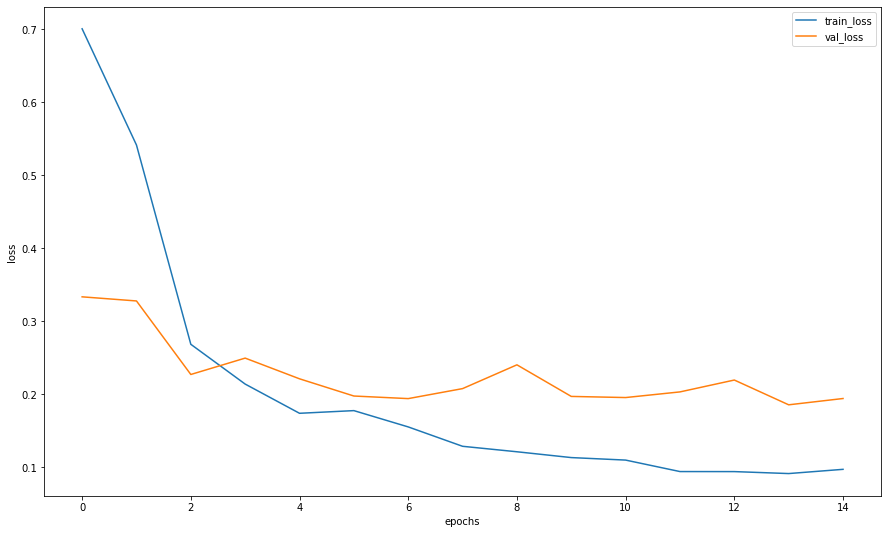

In [59]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [60]:
probs_ims = predict(model_google, imgs)
y_pred = np.argmax(probs_ims,-1)

In [61]:
f1_score(actual_labels, y_pred.tolist(),average='weighted')

0.9722222222222221

## На довольно небольшом количестве эпох удалось получить достойный результат 0.972
## На лидерборде выбили **0.97662**


In [62]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

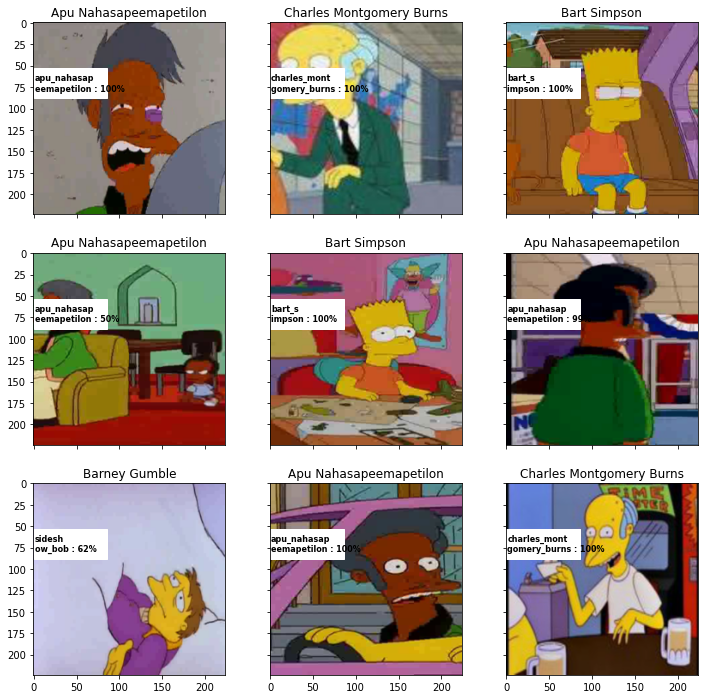

In [63]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_google, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [64]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_google, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


# SUB

In [65]:
d = {'Id':test_filenames, 'Expected':preds}
sub_1 = pd.DataFrame(data=d)
sub_1.to_csv('sub_1.csv', index=False)

In [66]:
pd.read_csv('sub_1.csv')

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum
